In [4]:
# Read data
import json_lines
X = []
y = []
z = []
with open('data.txt', 'rb') as f:
    for item in json_lines.reader(f):
        X.append(item['text'])
        y.append(item['voted_up'])
        z.append(item['early_access'])

In [31]:
from langdetect import detect

langs = {}

for i in range(len(X)):
    text = X[i]
    try:
        lang = detect(text)
    except:
        lang = 'symb'
    
    try:
        langs[lang] = langs[lang] + 1
    except:
        langs[lang] = 0
        
langs

{'zh-cn': 127,
 'en': 2053,
 'tr': 254,
 'af': 44,
 'bg': 47,
 'de': 195,
 'tl': 44,
 'ru': 826,
 'es': 176,
 'pt': 201,
 'it': 33,
 'pl': 108,
 'symb': 113,
 'fr': 90,
 'sq': 8,
 'ro': 22,
 'sk': 17,
 'so': 81,
 'vi': 13,
 'sl': 18,
 'da': 21,
 'cy': 26,
 'no': 19,
 'mk': 31,
 'ja': 27,
 'th': 20,
 'ko': 106,
 'et': 18,
 'hu': 30,
 'ca': 16,
 'uk': 23,
 'id': 23,
 'fi': 6,
 'nl': 45,
 'cs': 25,
 'sw': 13,
 'sv': 7,
 'hr': 26,
 'lv': 4,
 'lt': 1,
 'zh-tw': 2}

In [33]:
sum(list(langs.values()))

4959

In [34]:
len(X)

5000

In [36]:
# Data preparation
import numpy as np
X = np.array(X).reshape(-1, 1)

# Firstly, dummy baseline

F1: 0.0
Accuracy: 0.902


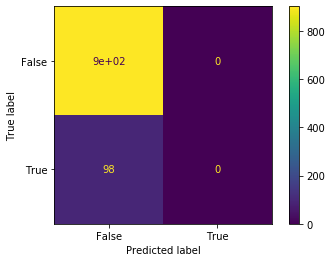

In [154]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, z, test_size=0.2)

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
plot_confusion_matrix(dummy_clf, X_test, y_test)

y_pred = dummy_clf.predict(X_test)
print('F1:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

# Feature Extraction

In [ ]:
# Translate to English
from google_trans_new import google_translator
t = google_translator()
X_trans = []
for i in range(len(X)):
    print(f'{i}/{len(X)}')
    row = X[i][0]
    X_trans.append(t.translate(row))

X_trans[0:5]

In [ ]:
import pandas as pd

# Cache features
df = pd.DataFrame(data=X_trans)
df.to_csv('translated_data.csv', index=False)

# Read Data

In [135]:
import pandas as pd

df = pd.read_csv('translated_data.csv')
X_trans = df.to_numpy()
X_trans = X_trans.flatten()

# Pre-processing
- Having all the text in English means that we can apply English pre-processing, such as tokenization, stemming etc.
- This will reduce the dimensionality of the input and thus make the model less complex.

### TF-IDF

In [96]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from langdetect import detect

def check_symb(s):
    try:
        detect(s)
    except:
        s = s + ' symb'
    return s

def remove_punc(s):
    return "".join([char for char in s if char not in string.punctuation])

def remove_stopwords(tokens):
    stop_words = stopwords.words('english')
    return [word for word in tokens if word not in stop_words]

def stem(tokens):
    porter = PorterStemmer()
    return [porter.stem(word) for word in tokens]

def to_bigrams(tokens):
    return list(bigrams(tokens))

# to lowercase
X_symb = list(map(check_symb, X_trans))
X_low = list(map(str.lower, X_symb))
X_punc = list(map(remove_punc, X_low))
X_tok = list(map(word_tokenize, X_punc))
X_stop = list(map(remove_stopwords, X_tok))
X_stemmed = list(map(stem, X_stop))

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x:x)
X_tfidf = tfidf.fit_transform(X_stemmed)

In [109]:
import scipy.sparse as sp

sp.save_npz('tfidf_features.npz', X_tfidf)

In [2]:
import scipy.sparse as sp

X_tfidf = sp.load_npz('tfidf_features.npz')
X_tfidf

<5000x13016 sparse matrix of type '<class 'numpy.float64'>'
	with 118761 stored elements in Compressed Sparse Row format>

### Word2Vec

In [5]:
from gensim.models import Doc2Vec

w2v = Doc2Vec(X_stemmed, min_count=3, size=100)
print(w2v)

NameError: name 'X_stemmed' is not defined

In [374]:
def doc_to_vec(tokens):
    vecs = []
    for t in tokens:
        try:
            vec = w2v[t]
            vecs.append(vec)
        except:
            pass
    if vecs != []:
        return np.array(vecs).mean(axis=0)
    else:
        return np.zeros(100)

X_w2v = [doc_to_vec(d) for d in X_stemmed]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### Train Test Split

In [375]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction
#svd = TruncatedSVD(n_components=1000)
#X_svd = svd.fit_transform(X_tfidf)

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2)

# Logistic Regression Model

In [376]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()
scores = cross_val_score(clf, X_w2v, y, cv=5)
print('Mean acc.:', scores.mean())

Mean acc.: 0.6138


In [159]:
from sklearn.svm import RidgeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

clf = RidgeClassifier()
scores = cross_val_score(clf, X_tfidf, y, cv=5)
print('Mean acc.:', scores.mean())

Mean acc.: 0.7522


### Regularisation Hyperparam Tuning

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

C = [0.01, 0.1, 1, 10, 100]
mean_scores = []
std_scores = []
for c in C:
    clf_l1 = LogisticRegression(penalty='l2', C=c)
    scores = cross_val_score(clf_l1, X_svd, y, cv=5)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

plt.errorbar(C, mean_scores, yerr=std_scores)
plt.xlabel('C')
plt.ylabel('Mean Accuracy')
plt.show()

# Support Vector Classifier

In [377]:
from sklearn.svm import SVC

clf_svc = SVC(kernel='rbf')
clf_svc.fit(X_train, y_train)
y_pred_svc = clf_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
print(accuracy_score(y_test, y_pred_svc))

              precision    recall  f1-score   support

       False       0.55      0.82      0.65       514
        True       0.59      0.28      0.38       486

    accuracy                           0.56      1000
   macro avg       0.57      0.55      0.52      1000
weighted avg       0.57      0.56      0.52      1000

0.556


In [28]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_train)

<1x13015 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

# Neural Network

In [356]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100)
model.fit(X_train, y_train)
y_pred_mlp =  model.predict(X_test)
print(classification_report(y_test, y_pred_mlp))
print(accuracy_score(y_test, y_pred_mlp))

              precision    recall  f1-score   support

       False       0.60      0.82      0.70       489
        True       0.74      0.48      0.58       511

    accuracy                           0.65      1000
   macro avg       0.67      0.65      0.64      1000
weighted avg       0.67      0.65      0.64      1000

0.648


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# MLP Cross-validation
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# KNN

In [378]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100, metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print(accuracy_score(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.58      0.75      0.65       514
        True       0.62      0.42      0.50       486

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.58      1000
weighted avg       0.60      0.59      0.58      1000

0.592


# Visualising Document Clusters
- Use PCA to convert each document to 2 dimensions.

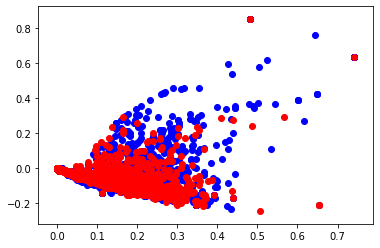

In [4]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

X_svd = TruncatedSVD(n_components=2).fit_transform(X_tfidf)
pos_X = X_svd[0:2500]
neg_X = X_svd[2500:5000]

plt.scatter(pos_X[:,0], pos_X[:,1], color='blue')
plt.scatter(neg_X[:,0], neg_X[:,1], color='red')